In [1]:
#!/usr/bin/python3
from sklearn.svm import OneClassSVM
import pandas as pd
import feather
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import pickle
np.random.seed(500)
import time
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold

In [3]:
pickle_in = open("df_lemma_yelp_chicago_rest.pickle","rb")
df = pickle.load(pickle_in)
# df = pd.read_table("Data/YelpChi/output_review_yelpHotelData_NRYRcleaned.txt",header=None)
# df2 = pd.read_table("Data/YelpChi/output_meta_yelpHotelData_NRYRcleaned.txt",header=None, sep=" ")
# df['label'] =  df2[4]
# df['label'] = df['label'].replace(['N'],1)
# df['label'] = df['label'].replace(['Y'],-1)
# df.columns = ['review_content', 'label']

In [4]:
df

,review_content,label,tokenized,text_final
0,"unlike next, which we'd eaten at the previous ...",1,"[unlike, next, ,, which, we, 'd, eaten, at, th...","['unlike', 'next', 'eat', 'previous', 'night',..."
1,probably one of the best meals i've had ever. ...,1,"[probably, one, of, the, best, meals, i, 've, ...","['probably', 'one', 'best', 'meal', 'ever', 'p..."
2,service was impeccable. experience and present...,1,"[service, was, impeccable, ., experience, and,...","['service', 'impeccable', 'experience', 'prese..."
3,"the problem with places like this, given the e...",1,"[the, problem, with, places, like, this, ,, gi...","['problem', 'place', 'like', 'give', 'exhorbit..."
4,i have no idea how to write my review - dining...,1,"[i, have, no, idea, how, to, write, my, review...","['idea', 'write', 'review', 'dining', 'alinea'..."
...,...,...,...,...
61533,i've passed this place a bunch of times on my ...,1,"[i, 've, passed, this, place, a, bunch, of, ti...","['pass', 'place', 'bunch', 'time', 'way', 'oly..."
61534,rubino's is not really setup as a retail opera...,1,"[rubino, 's, is, not, really, setup, as, a, re...","['rubino', 'really', 'setup', 'retail', 'opera..."
61535,this place is amazing. the food is great and y...,1,"[this, place, is, amazing, ., the, food, is, g...","['place', 'amaze', 'food', 'great', 'beat', 'p..."
61536,ok went back the next day as i was driving by ...,1,"[ok, went, back, the, next, day, as, i, was, d...","['ok', 'go', 'back', 'next', 'day', 'drive', '..."


In [5]:
pos=0 
neg = 0

for x in df['label']:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  8141  positive: 53397 total 61538 percent deceptive 13.229224219181644


In [6]:
#file_path = '/home/parallels/KTH/II2202/Data/YelpNYC/database_feather.feather'
#df = pd.read_feather(file_path, columns=None, use_threads=True)

In [7]:
df.dtypes

review_content    object
label              int64
tokenized         object
text_final        object
dtype: object

In [8]:
df.describe()

,label
count,61538.000000
mean,0.735416
std,0.677622
min,-1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [9]:
# # Step - a : Remove blank rows if any.
# df['review_content'].dropna(inplace=True)

In [10]:
# # Step - b : Change all the text to lower case
# df['review_content'] = [entry.lower() for entry in df['review_content']]

In [11]:
# # Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
# # tokenized = []
# # for index,entry in enumerate(genuine['review_content']): 
# #     genuine.loc[index,'tokenized'] = [word_tokenize(entry)]
# #     percent = index/len(genuine)*100
# #     print('percent done [%d%%]\r'%percent, end="")
# df['tokenized']= [word_tokenize(entry) for entry in df['review_content']]

In [12]:
# # Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
# tag_map = defaultdict(lambda : wn.NOUN)
# tag_map['J'] = wn.ADJ
# tag_map['V'] = wn.VERB
# tag_map['R'] = wn.ADV
# final_text = [None]*len(df['tokenized'])
# for index,entry in enumerate(df['tokenized']):
#     # Declaring Empty List to store the words that follow the rules for this step
#     Final_words = []
#     # Initializing WordNetLemmatizer()
#     percent = float(index/len(df['tokenized'])*100)

#     print('percent done [%f%%]\r'%percent, end="")
#     word_Lemmatized = WordNetLemmatizer()
#     # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
#     for word, tag in pos_tag(entry):
#         # Below condition is to check for Stop words and consider only alphabets
#         if word not in stopwords.words('english') and word.isalpha():
#             word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
#             Final_words.append(word_Final)
#     # The final processed set of words for each iteration will be stored in 'text_final'
#     df.loc[index,'text_final'] = str(Final_words)
#     final_text[index]=(Final_words)
    


In [13]:
# #to save the preporcessed list

# pickle_out = open("df_lemma_yelp_chicago.pickle","wb")
# pickle.dump(df, pickle_out)
# pickle_out.close()

In [14]:
x = df['text_final'].values.reshape(-1,1)
y = df['label'].values.reshape(-1,1)
y.shape

(61538, 1)

In [15]:
#undersample = RandomUnderSampler(sampling_strategy='majority')
undersample = RandomUnderSampler(sampling_strategy='majority')
#oversample = RandomOverSampler(sampling_strategy='minority')
X_under, y_under = undersample.fit_resample(x, y)
#X_over, y_over = oversample.fit_resample(X, df['label'])

In [16]:
d = {'text_final':X_under[:,0],'label':y_under[:,]}
dfu = pd.DataFrame(d)

In [17]:
dfu

,text_final,label
0,"['like', 'service', 'offer', 'alinea', 'restau...",-1
1,"['presumably', 'one', 'best', 'restaurant', 'a...",-1
2,"['truly', 'amazing', 'experience', 'ever', 're...",-1
3,"['go', 'friend', 'birthday', 'say', 'wow', 'fi...",-1
4,"['nutshell', 'sophisticated', 'place', 'good',...",-1
...,...,...
16277,"['usually', 'yelp', 'place', 'drive', 'say', '...",1
16278,"['three', 'thing', 'love', 'free', 'valet', 'f...",1
16279,"['fresh', 'fast', 'cheap', 'falafel', 'sandwic...",1
16280,"['come', 'restaurant', 'crappy', 'get', 'valle...",1


In [18]:
pos=0 
neg = 0
for x in dfu['label']:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  8141  positive: 8141 total 16282 percent deceptive 50.0


In [19]:
Train_X_oc_all, Test_X_oc_all = model_selection.train_test_split(dfu[['label','text_final']],test_size=0.3)

In [20]:
# check test genuine/deceptive
pos=0 
neg = 0

for x in Test_X_oc_all['label']:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  2430  positive: 2455 total 4885 percent deceptive 49.744114636642784


In [21]:
# split using genuine
Train_X, Test_X = model_selection.train_test_split((Train_X_oc_all.loc[(dfu['label'] == 1)]).text_final,test_size=0.3)


In [22]:
#split using deceptive
Train_X_dec, Test_X_dec = model_selection.train_test_split((Train_X_oc_all.loc[(dfu['label'] == -1)]).text_final,test_size=0.3)

In [23]:
Tfidf_vect = TfidfVectorizer(max_features=400)        
Tfidf_vect.fit(df['text_final'])

TfidfVectorizer(max_features=400)

In [24]:
#vectorizing genuine data
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [25]:
# vectorizing deceptive data
Train_X_Tfidf_dec = Tfidf_vect.transform(Train_X_dec)
Test_X_Tfidf_dec = Tfidf_vect.transform(Test_X_oc_all['text_final'])

In [26]:
# vectorizing all data
Test_X_Tfidf_all = Tfidf_vect.transform(df['text_final'])

In [27]:
Train_X_Tfidf

<3980x400 sparse matrix of type '<class 'numpy.float64'>'
	with 131905 stored elements in Compressed Sparse Row format>

In [28]:
# fit the training dataset on the classifier using [deceptive]
start_time = time.time()

clf_dec = OneClassSVM(gamma='auto', kernel='rbf', degree=5).fit(Train_X_Tfidf_dec)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# predict the labels on validation dataset

elapsed_time 4.744605541229248


In [29]:
# predict using deceptive
start_time = time.time()
predictions_oneclass_dec = clf_dec.predict(Test_X_Tfidf_dec)
#print(predictions_oneclass_dec)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# Use accuracy_score function to get the accuracy

elapsed_time 2.8502578735351562


In [30]:
# deceptive predict count
pos=0 
neg = 0

for x in predictions_oneclass_dec:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos)       

negative:  2270  positive: 2615


In [31]:
cf_matrix=confusion_matrix(Test_X_oc_all['label'], predictions_oneclass_dec*-1)
metrics_result = precision_recall_fscore_support(Test_X_oc_all['label'], predictions_oneclass_dec*-1, average='weighted',zero_division=0)
print("Accuracy Score -> ",accuracy_score(predictions_oneclass_dec*-1, Test_X_oc_all['label'], normalize=True))
print("percision: ", metrics_result[0], ' recall: ' , metrics_result[1], ' fscore: ', metrics_result[2])
#print(metrics.f1_score(Test_X_oc_all['label'], predictions_oneclass_dec*-1, average='weighted'))
#sns.heatmap(cf_matrix, annot=True)

Accuracy Score ->  0.4532241555783009
percision:  0.4531674707230339  recall:  0.4532241555783009  fscore:  0.45254520517972374


<AxesSubplot:>

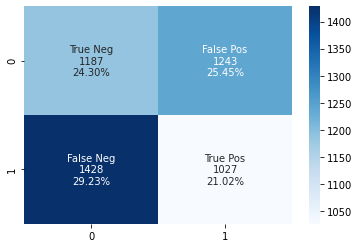

In [32]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


In [33]:
# fit the training dataset on the classifier using [genuine]
start_time = time.time()

clf_gen = OneClassSVM(gamma='auto', kernel='poly', degree=5).fit(Train_X_Tfidf)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# predict the labels on validation dataset

elapsed_time 3.4906880855560303


In [34]:
# predict using [genuine]
start_time = time.time()
predictions_oneclass_gen = clf_gen.predict(Test_X_Tfidf_dec)
#print(predictions_oneclass_gen)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# Use accuracy_score function to get the accuracy

elapsed_time 3.476022720336914


In [35]:
# count of prediction using [genuine]
pos=0 
neg = 0

for x in predictions_oneclass_gen:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos)   

negative:  4856  positive: 29


In [36]:
print("Accuracy Score -> ",accuracy_score(predictions_oneclass_gen, Test_X_oc_all['label'], normalize=True))

Accuracy Score ->  0.49887410440122826


In [37]:
# # to save the classifier model

# pickle_out = open("clf_oneclass.pickle","wb")
# pickle.dump(clf, pickle_out)
# pickle_out.close()

In [38]:
X_train_all, X_validation_all, Y_train_all, Y_validation_all = train_test_split(Tfidf_vect.transform(dfu['text_final']), dfu['label'], test_size=0.30, random_state=1,stratify=dfu['label'] )

In [39]:
print(len(dfu['text_final']),len(Y_train_all))

16282 11397


In [40]:
pos=0 
neg = 0
for x in Y_train_all:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  5699  positive: 5698 total 11397 percent deceptive 50.00438711941739


In [42]:
# classifier checker

# your code
models = []
#models.append(['Logistic Regression', LogisticRegression(solver='liblinear', multi_class='ovr'),[],0,0])
#models.append(['Linear Discriminant Analysis', LinearDiscriminantAnalysis(),[],0,0])
#models.append(['K Nearest Neighbor', KNeighborsClassifier(),[],0,0])
#models.append(['Decesion Tree Classifier', DecisionTreeClassifier(),[],0,0])
#models.append(['Gaussien Naive Bayes', GaussianNB(),[],0,0])
models.append(['Support Vector Machine', SVC(gamma='auto',kernel='rbf'),[],0,0])
models.append(['Support Vector Machine', SVC(gamma='auto',kernel='poly'),[],0,0])
models.append(['Support Vector Machine', SVC(gamma='auto',kernel='linear'),[],0,0])
#models.append(['Random Forest', RandomForestClassifier(max_depth = 1000,random_state=1),[],0,0])

models = np.array(models,dtype=object)

for i in range(len(models)):
    start_time = time.time()
    #kfold = StratifiedKFold(n_splits=1, random_state=1, shuffle=True)
    cv_results = cross_val_score(models[i,1], X_train_all, Y_train_all, scoring='accuracy')
    models[i,2] = cv_results
    models[i,3] = cv_results.mean()
    models[i,4] = cv_results.std()
    elapsed_time = time.time() - start_time
    print('%s: %f (%f) elapsed time: %f' % (models[i,0], models[i,3], models[i,4],elapsed_time))
    
    

best_model= models[np.argmax(models[:,3]),:]
print("the best model performer is: ", best_model[0])

Support Vector Machine: 0.564366 (0.046945) elapsed time: 272.431864
Support Vector Machine: 0.528039 (0.034897) elapsed time: 265.189305
Support Vector Machine: 0.646136 (0.008003) elapsed time: 219.930950
the best model performer is:  Support Vector Machine


In [43]:
clf_model=SVC(gamma='auto',kernel='linear',degree=2).fit(X_train_all, Y_train_all)

In [44]:
result=clf_model.predict(X_validation_all)

In [45]:
pos=0 
neg = 0
for x in result:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  2557  positive: 2328 total 4885 percent deceptive 52.3439099283521


In [70]:
print("Accuracy Score -> ",accuracy_score(result, Y_validation_all, normalize=True))
metrics_result = precision_recall_fscore_support(Y_validation_all, result, average='binary',zero_division=0)
print("percision: ", metrics_result[0], ' recall: ' , metrics_result[1], ' fscore: ', metrics_result[2], '\n') 

Accuracy Score ->  0.6325486182190379
percision:  0.6391752577319587  recall:  0.6090871878837495  fscore:  0.6237686019702368 



In [47]:
df2= df[['text_final','label']]

In [48]:
df3= pd.concat([df2, dfu]).drop_duplicates(keep=False)

In [49]:
pos=0 
neg = 0
for x in df3['label']:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  0  positive: 45213 total 45213 percent deceptive 0.0


In [50]:
# split using genuine
perc=(1- len(Y_train_all)/len(df3))
Train_X_oneclass, Test_X_oneclass = model_selection.train_test_split((df3.loc[(df['label'] == 1)]).text_final,test_size=perc)

In [51]:
Train_X_oneclass.shape

(11397,)

In [52]:
# max_features = 100;
# while max_features < 5000:
#     Tfidf_vect = TfidfVectorizer(max_features=max_features)        
#     Tfidf_vect.fit(df['text_final'])
#     Train_X_Tfidf = Tfidf_vect.transform(Train_X)
#     Test_X_Tfidf = Tfidf_vect.transform(Test_X)
#     Train_X_Tfidf_dec = Tfidf_vect.transform(Train_X_dec)
#     Test_X_Tfidf_dec = Tfidf_vect.transform(Test_X_oc_all['text_final'])
#     one_class_train = Tfidf_vect.transform(Train_X_oneclass)
    
#     clf_result = OneClassSVM( kernel='poly', degree=2).fit(one_class_train)
#     predict_result = clf_result.predict(Test_X_Tfidf_dec)
#     acc = accuracy_score(predict_result*1, Test_X_oc_all['label'], normalize=True)
#     metrics_result = precision_recall_fscore_support(Test_X_oc_all['label'], predict_result*1, average='weighted',zero_division=0)
#     print('features used: ', max_features, ' accuracy: ', acc)
#     print("percision: ", metrics_result[0], ' recall: ' , metrics_result[1], ' fscore: ', metrics_result[2], '\n')  
    
#     max_features += 100

In [53]:
one_class_train = Tfidf_vect.transform(Train_X_oneclass)

In [54]:
one_class_train

<11397x400 sparse matrix of type '<class 'numpy.float64'>'
	with 378736 stored elements in Compressed Sparse Row format>

In [55]:
# fit the training dataset on the classifier
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = [0,1,2,3]
classifiers = []
for kern in kernels:
    start_time = time.time()
    if kern == 'poly':
        for deg in degrees:
            start_time = time.time()
            clf_result = OneClassSVM( kernel=kern, degree=deg).fit(one_class_train)
            elapsed_time = time.time() - start_time
            classifiers.append([kern,deg,clf_result,elapsed_time])
            print('kernel used: ' , kern, ' degree used: ' , deg, ' elapsed_time:' , elapsed_time)
            
    else:
        clf_result = OneClassSVM(gamma='auto', kernel=kern).fit(Train_X_Tfidf_dec)
        elapsed_time = time.time() - start_time
        classifiers.append([kern,0,clf_result,elapsed_time])
        print('kernel used: ' , kern, ' elapsed_time: ' , elapsed_time)

# predict the labels on validation dataset

kernel used:  linear  elapsed_time:  5.620898246765137
kernel used:  poly  degree used:  0  elapsed_time: 32.24312901496887
kernel used:  poly  degree used:  1  elapsed_time: 58.96566104888916
kernel used:  poly  degree used:  2  elapsed_time: 60.076799392700195
kernel used:  poly  degree used:  3  elapsed_time: 65.09239649772644
kernel used:  poly  degree used:  5  elapsed_time: 223.27369785308838
kernel used:  poly  degree used:  7  elapsed_time: 220.8226420879364
kernel used:  poly  degree used:  9  elapsed_time: 218.18938565254211
kernel used:  rbf  elapsed_time:  4.273554086685181
kernel used:  sigmoid  elapsed_time:  4.207171440124512


In [71]:
clas_result = []
for clas in classifiers:
    start_time = time.time()
    predict_result = clas[2].predict(Test_X_Tfidf_dec)
    elapsed_time = time.time() - start_time
    clas_result.append([clas[0],clas[1],clas[2],predict_result])
    acc = accuracy_score(predict_result*1, Test_X_oc_all['label'], normalize=True)
    metrics_result = precision_recall_fscore_support(Test_X_oc_all['label'], predict_result*1, average='binary',zero_division=0)
    print('kernel used: ' , clas[0], ' degree used:' , clas[1], ' elapsed_time: ' , elapsed_time, ' accuracy: ', acc)
    print("percision: ", metrics_result[0], ' recall: ' , metrics_result[1], ' fscore: ', metrics_result[2], '\n')  
# predict the labels on validation dataset

kernel used:  linear  degree used: 0  elapsed_time:  2.5374674797058105  accuracy:  0.5471852610030706
percision:  0.5464627151051625  recall:  0.5820773930753564  fscore:  0.5637080867850099 

kernel used:  poly  degree used: 0  elapsed_time:  12.72238302230835  accuracy:  0.49744114636642783
percision:  0.0  recall:  0.0  fscore:  0.0 

kernel used:  poly  degree used: 1  elapsed_time:  14.239993572235107  accuracy:  0.5707267144319345
percision:  0.5861405197305101  recall:  0.4961303462321792  fscore:  0.5373924553275976 

kernel used:  poly  degree used: 2  elapsed_time:  14.941925764083862  accuracy:  0.5690890481064483
percision:  0.5863770977295163  recall:  0.4839103869653768  fscore:  0.5302387859852712 

kernel used:  poly  degree used: 3  elapsed_time:  14.786422729492188  accuracy:  0.5643807574206755
percision:  0.5887140531741726  recall:  0.4419551934826884  fscore:  0.504885993485342 

kernel used:  poly  degree used: 5  elapsed_time:  23.518736124038696  accuracy:  0.

<AxesSubplot:>

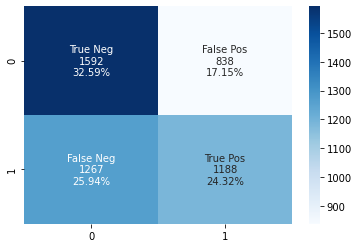

In [57]:
clf_result = OneClassSVM( kernel='poly', degree=2).fit(one_class_train)
predict_result = clf_result.predict(Test_X_Tfidf_dec)

cf_matrix=confusion_matrix(Test_X_oc_all['label'], predict_result*1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Accuracy', 'Elapsed Time']
multi_class = [64.6, 219]
one_class = [57.1, 72]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent')
ax.set_title('Yelp Chicago Resturant Results [multi-class vs. one-class SVM]')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()